##In this iPython Notebook Tutorial, you can play with the Poisson spiking neuron simulation to see how increased firing influences the slope of the ECoG PSD. 

Step through the tutorial for a full explanation of what is happening, or go straight to the last block (after running the import block) to play with the simulation.

In [3]:
#FOR INTERACTIVE PLOTTING, RUN IMPORT BLOCK THEN LAST BLOCK
import scipy as sp
import pylab as plt
from sklearn import linear_model
from scipy import signal
from IPython.html.widgets import interactive, FloatSliderWidget, fixed, interaction
from IPython.display import display
%matplotlib inline

#parameter definition
N_neurons = 10000.              #number of poisson neurons
dt = 1.0/1000.                  #time step
t_end = 5                      #seconds
t = sp.linspace(0,t_end,int(t_end/dt)) #time vector
ran_block = sp.random.uniform(0,1,(N_neurons,len(t))); #random matrix, threshold to make spikes

#####Define a population of spiking neurons...
by thresholding N (N being the number of neurons) stream of randomly generated, uniformly distributed numbers. This actually gives you a Bernoulli process, but in the limit of infinitesmal time bins, we approach a Poisson process.

We will see what the summed signal (LFP) looks like in time domain and in frequency domain (its PSD).

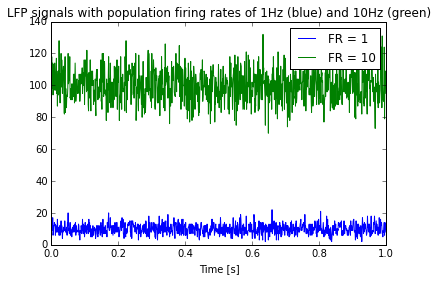

In [7]:
FR = sp.array([1,10]);
lam = FR * dt;
LFP = sp.zeros([len(lam), len(t)])
#get LFP from summed spikes and plot
plt.figure()
for i in range(0,len(lam)):
    LFP[i,:] = sp.sum((ran_block<lam[i]).astype(int),0);
    plt.plot(t[0:1000],LFP[i,0:1000], label="FR = " + str(FR[i]))

plt.legend(); plt.xlabel("Time [s]"); 
plt.title('LFP signals with population firing rates of 1Hz (blue) and 10Hz (green)')

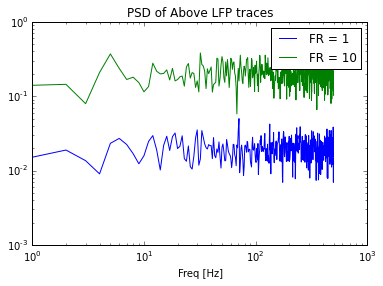

In [10]:
#calculate PSD and plot
Fa, Pxx = signal.welch(LFP,nperseg=1000, fs=1000)
plt.figure()
for i in range(0,len(lam)):
    plt.loglog(Fa,Pxx[i,:], label="FR = " + str(FR[i]))

plt.legend(); plt.xlabel("Freq [Hz]")
plt.title('PSD of Above LFP traces')

Note that the PSD of the two traces are both relatively flat, with the main difference being a constant offset.

######Now, we add these two signals to the same 1/f spectrum, and robustly fit a line to the log-log representation to find the slope and intersection frequency.

------- Firing rate = 1
Fitted slope =  -2.93172453259
Intersection Frequency =  23.0 Hz
------- Firing rate = 10
Fitted slope =  -2.48527437451
Intersection Frequency =  22.0 Hz


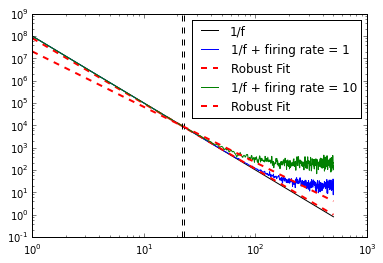

In [12]:
Fa, Pxx = signal.welch(LFP,nperseg=1000)
Fa = Fa*1000.
PpowLaw = 1e8*sp.power((Fa),-3) #1/f^2 powerlaw PSD
Ptot = PpowLaw+Pxx
fit_range = sp.arange(10,100)
plt.figure()
plt.loglog(Fa,PpowLaw, 'k', label="1/f")
for i in range(0,len(FR)):
    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(sp.log10(Fa[fit_range, sp.newaxis]), sp.log10(Ptot[i,fit_range]))
    fit_line = model_ransac.predict(sp.log10(Fa[1:,sp.newaxis]))

    #find line of intersection with baseline power law PSD
    intersect = Fa[sum(((sp.power(10,fit_line[:,0]) - PpowLaw[1:])<0).astype(int))+1] 

    plt.loglog(Fa, Ptot[i,:], label="1/f + firing rate = " + str(FR[i]))
    plt.loglog(Fa[1:],sp.power(10,fit_line), '--r', linewidth=2., label="Robust Fit")
    plt.loglog([intersect, intersect], plt.ylim(), 'k--')
    
    print "------- Firing rate = " + str(FR[i])
    print "Fitted slope = " , model_ransac.estimator_.coef_[0][0]
    print "Intersection Frequency = ", intersect, "Hz"

plt.legend();plt.show()

###Now we can vary the Poisson firing rate with a slider to see in (almost) real-time, how increasing firing rate changes the PSD slope and intersection frequency.

Be gentle with the slider, the simulation has to run in real time to output the spiking neuron LFP so depending on how fast your computer is, you might have to wait a second or two.

------- Firing rate = 2.51188643151
Fitted slope =  -2.84023632689


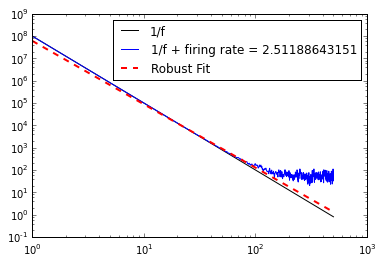

In [16]:
#INTERACTIVE PLOT
def changeFR(logFR):
    FR = sp.power(10,logFR)
    lam = FR * dt;
    #get LFP from summed spikes and plot
    LFP = sp.sum((ran_block<lam).astype(int),0);
    Fa, Pxx = signal.welch(LFP,nperseg=1000)
    Fa = Fa*1000.
    PpowLaw = 1e8*sp.power((Fa),-3) #1/f powerlaw PSD
    Ptot = PpowLaw+Pxx
    fit_range = sp.arange(10,100)
    plt.figure()
    plt.loglog(Fa,PpowLaw, 'k', label="1/f")
 
    #Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(sp.log10(Fa[fit_range, sp.newaxis]), sp.log10(Ptot[fit_range]))
    fit_line = model_ransac.predict(sp.log10(Fa[1:,sp.newaxis]))


    plt.loglog(Fa, Ptot, label="1/f + firing rate = " + str(FR))
    plt.loglog(Fa[1:],sp.power(10,fit_line), '--r', linewidth=2., label="Robust Fit")
    
    print "------- Firing rate = " + str(FR)
    print "Fitted slope = " , model_ransac.estimator_.coef_[0][0]
    plt.legend();plt.show()
    
 
slider = interaction.interact(changeFR,
                     logFR = FloatSliderWidget(min = -2, max = 2, step = 0.2, value = 0, msg_throttle=1 ))
display(slider)